## Notebook Accompanying Email #5: Mean Reversion in Stocks

## Magic

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import urllib3
import datetime as dt
import numpy as np
import plotnine as p9
import polars as pl
import pandas as pd
import yfinance as yf
import requests
import io
import statsmodels.formula.api as smf

# urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## Options / Globals

In [3]:
p9.options.figure_size = (12, 5)

## Get SPY Constituents from State Street

In [4]:
constituents = 'https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx'

In [5]:
response = requests.get(constituents)

In [6]:
const_df = (
    pd
    .read_excel(io=io.BytesIO(response.content), skiprows=3, header=1, skipfooter=85)
    .assign(Weight=lambda x: x['Weight'] / 100.0)
    .query('Name != "US DOLLAR"')
)
symbols = sorted(list(map(lambda x : x.replace(".","-"), list(const_df['Ticker']) + ['SPY'])))

## Download Prices for each constituent from Yahoo Finance

In [7]:
# Yahoo Finance produces Pandas DataFrames

tickers = yf.Tickers(symbols)
yahoo_data = tickers.download(period="max",auto_adjust=True)

[*********************100%%**********************]  504 of 504 completed


In [10]:
# Convert the pandas dataframe to a Polars dataframe

yd = pl.from_dataframe(yahoo_data.stack(1, future_stack=True).reset_index().assign(Date=lambda x: pd.to_datetime(x['Date']).dt.tz_localize(None)))

## Save data so that next time we don't have to grab it from the web

In [11]:
yd.write_parquet('spy.parquet')

## Load pre-saved data if it exists, to save time

In [ ]:
yd = pl.read_parquet('spy.parquet')

## Select the price data we need.  Will look post 2000

In [12]:
yd1 = (
    yd
    .select(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close'])
    .drop_nulls()
    .filter(pl.col('Date') > dt.datetime(2000,1,1))
    .sort(['Date', 'Ticker'])
)

## Get a feel for survivorship bias

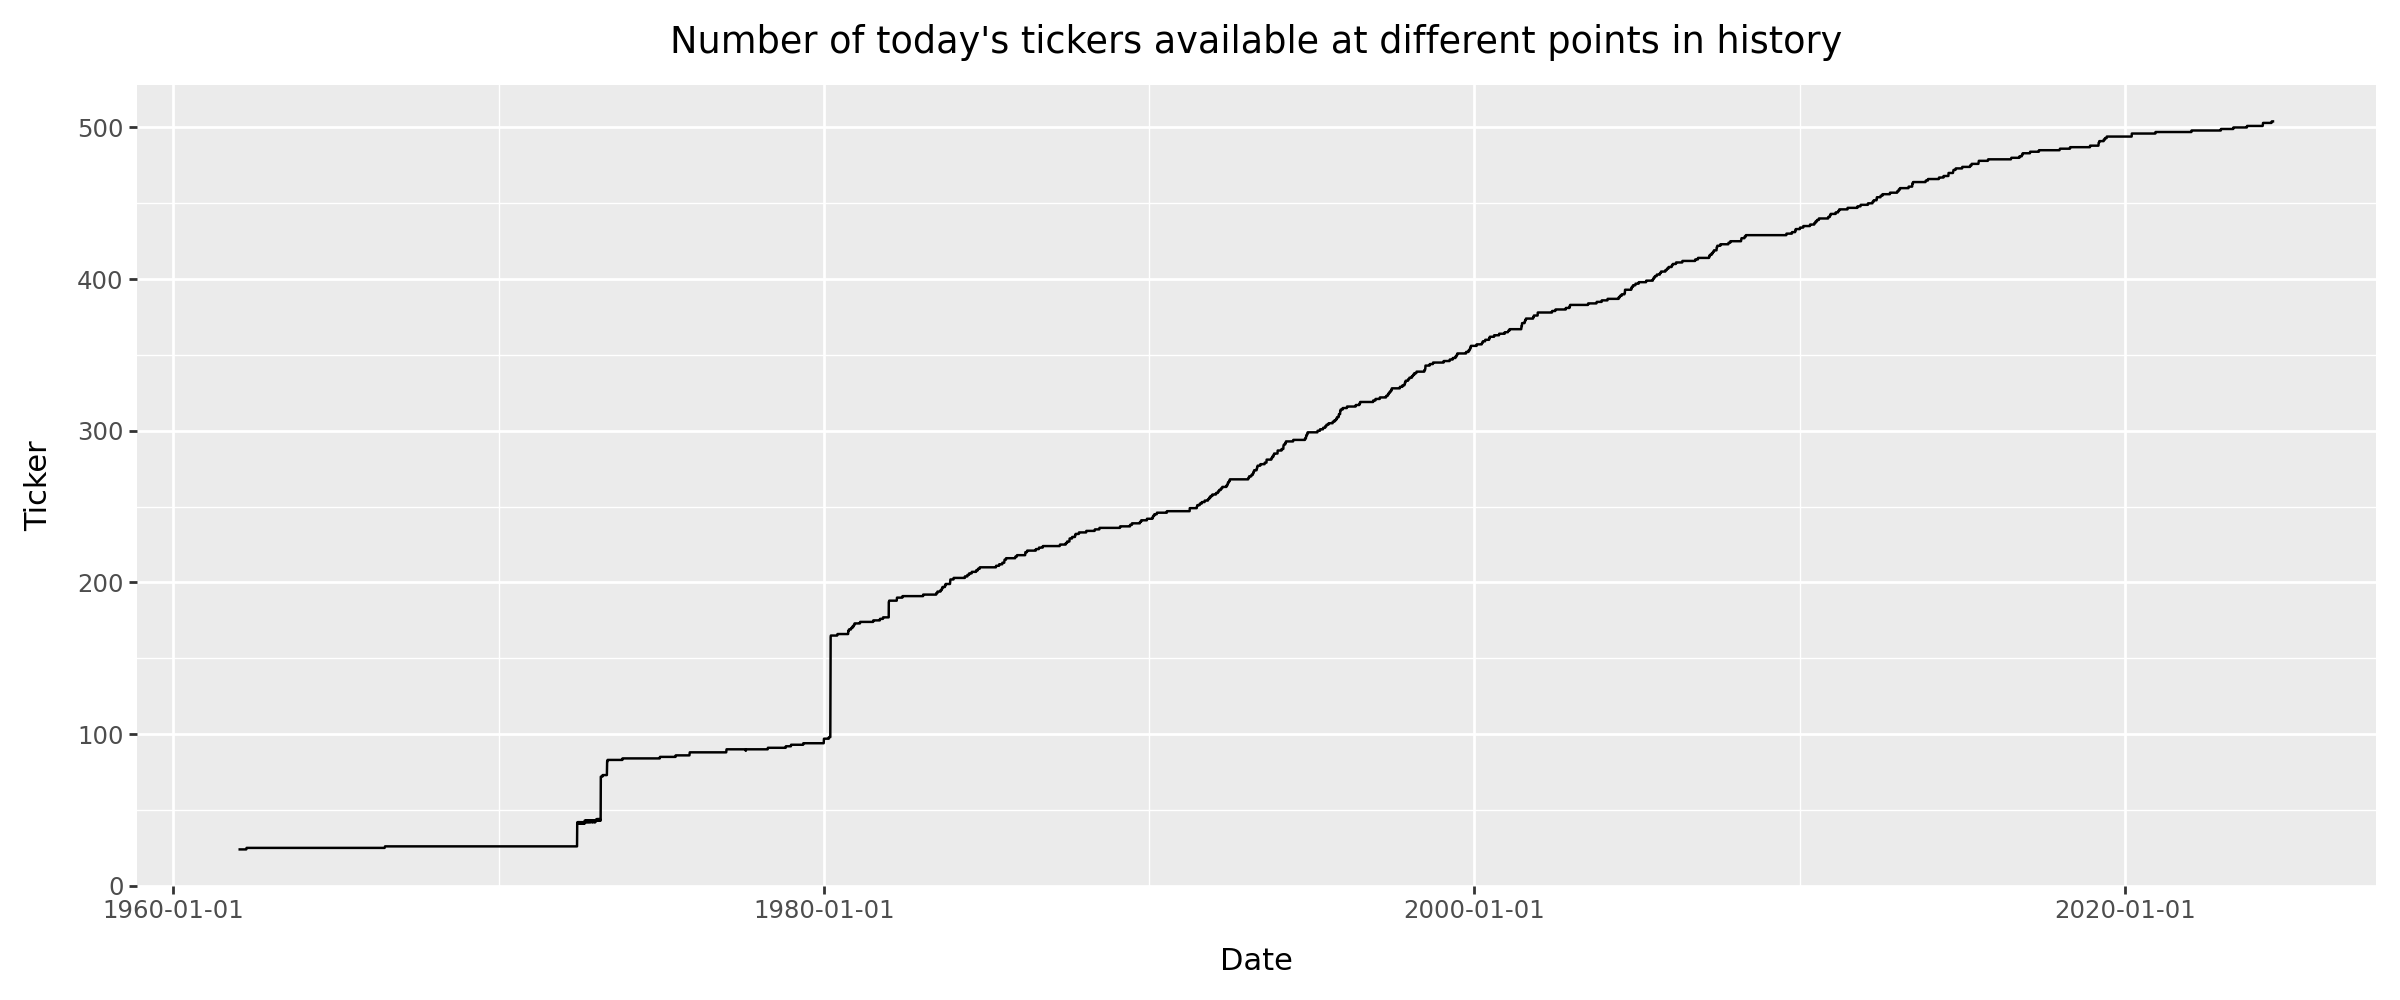

In [13]:
(
    yd
    .select(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close'])
    .drop_nulls()
    .group_by('Date', maintain_order=True)
    .agg( pl.col('Ticker').count())
    .pipe(p9.ggplot)
    + p9.aes(x='Date', y='Ticker')
    + p9.geom_line()
    + p9.ggtitle("Number of today's tickers available at different points in history")
)

## Create 1-day returns and 1-day future returns and mash up the results to find a general pattern

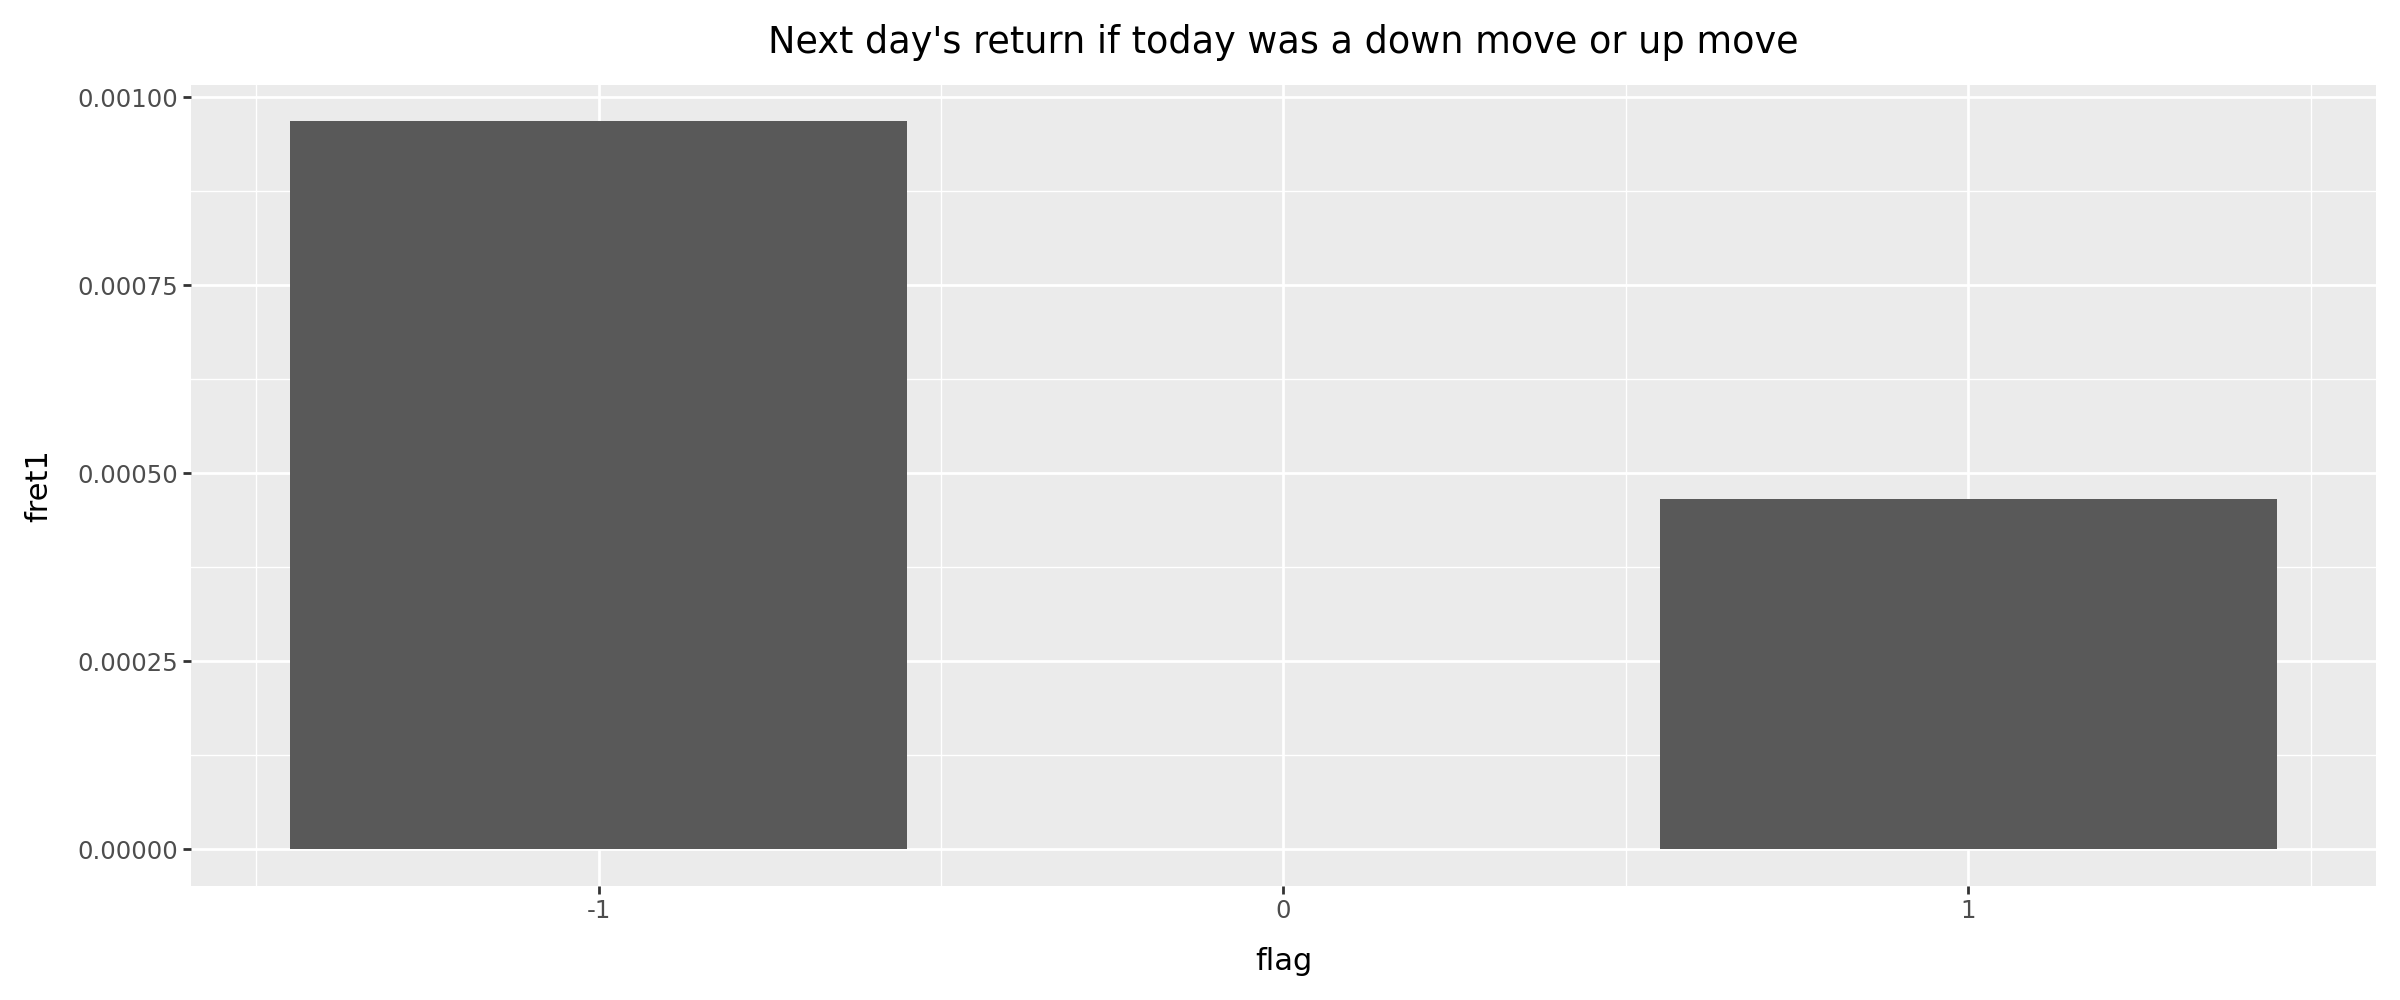

In [14]:
# yd_features = 
(
    yd1
    .group_by('Ticker', maintain_order=True)
    .agg(
        pl.all(), 
        pl.col('Close').pct_change(1).alias('ret1'),
        pl.col('Close').pct_change(1).shift(-1).alias('fret1')
    )
    .explode(pl.exclude('Ticker'))
    
    .drop_nulls()
    
    .with_columns(
        pl.when(pl.col('ret1') < 0).then(-1).otherwise(1).alias('flag')
    )
    
    .group_by('flag', maintain_order=True)
    .agg(
        pl.col('fret1').mean()
    )
    
    .pipe(p9.ggplot)
    + p9.aes(x='flag', y='fret1')
    + p9.geom_bar(stat='identity')
    + p9.ggtitle("Next day's return if today was a down move or up move")

)

## Bin the previous day's stock returns to see if next day's stock returns have a dependency on them

In [15]:
SHIFT = 1
NUM_QUANTILES = 10
LABELS = [str(x) for x in range(NUM_QUANTILES)]

ydq_1 = (
    yd1
    .group_by('Ticker', maintain_order=True)
    .agg(
        pl.all(), 
        pl.col('Close').pct_change(SHIFT).alias('ret'),
        pl.col('Close').pct_change(SHIFT).shift(-SHIFT).alias('fret')
    )
    .explode(pl.exclude('Ticker'))

    .drop_nulls()
    
    .with_columns(
        pl.col('ret')
        .qcut(quantiles=NUM_QUANTILES, labels=LABELS, allow_duplicates=True)
        .over("Date")
        .alias('ret_q').cast(pl.UInt32)
    )
)

if SHIFT > 1:
    date_selection = ydq_1.select('Date').unique().sort(by='Date').gather_every(SHIFT)
    ydq_1 = ydq_1.filter(pl.col('Date').is_in(date_selection))

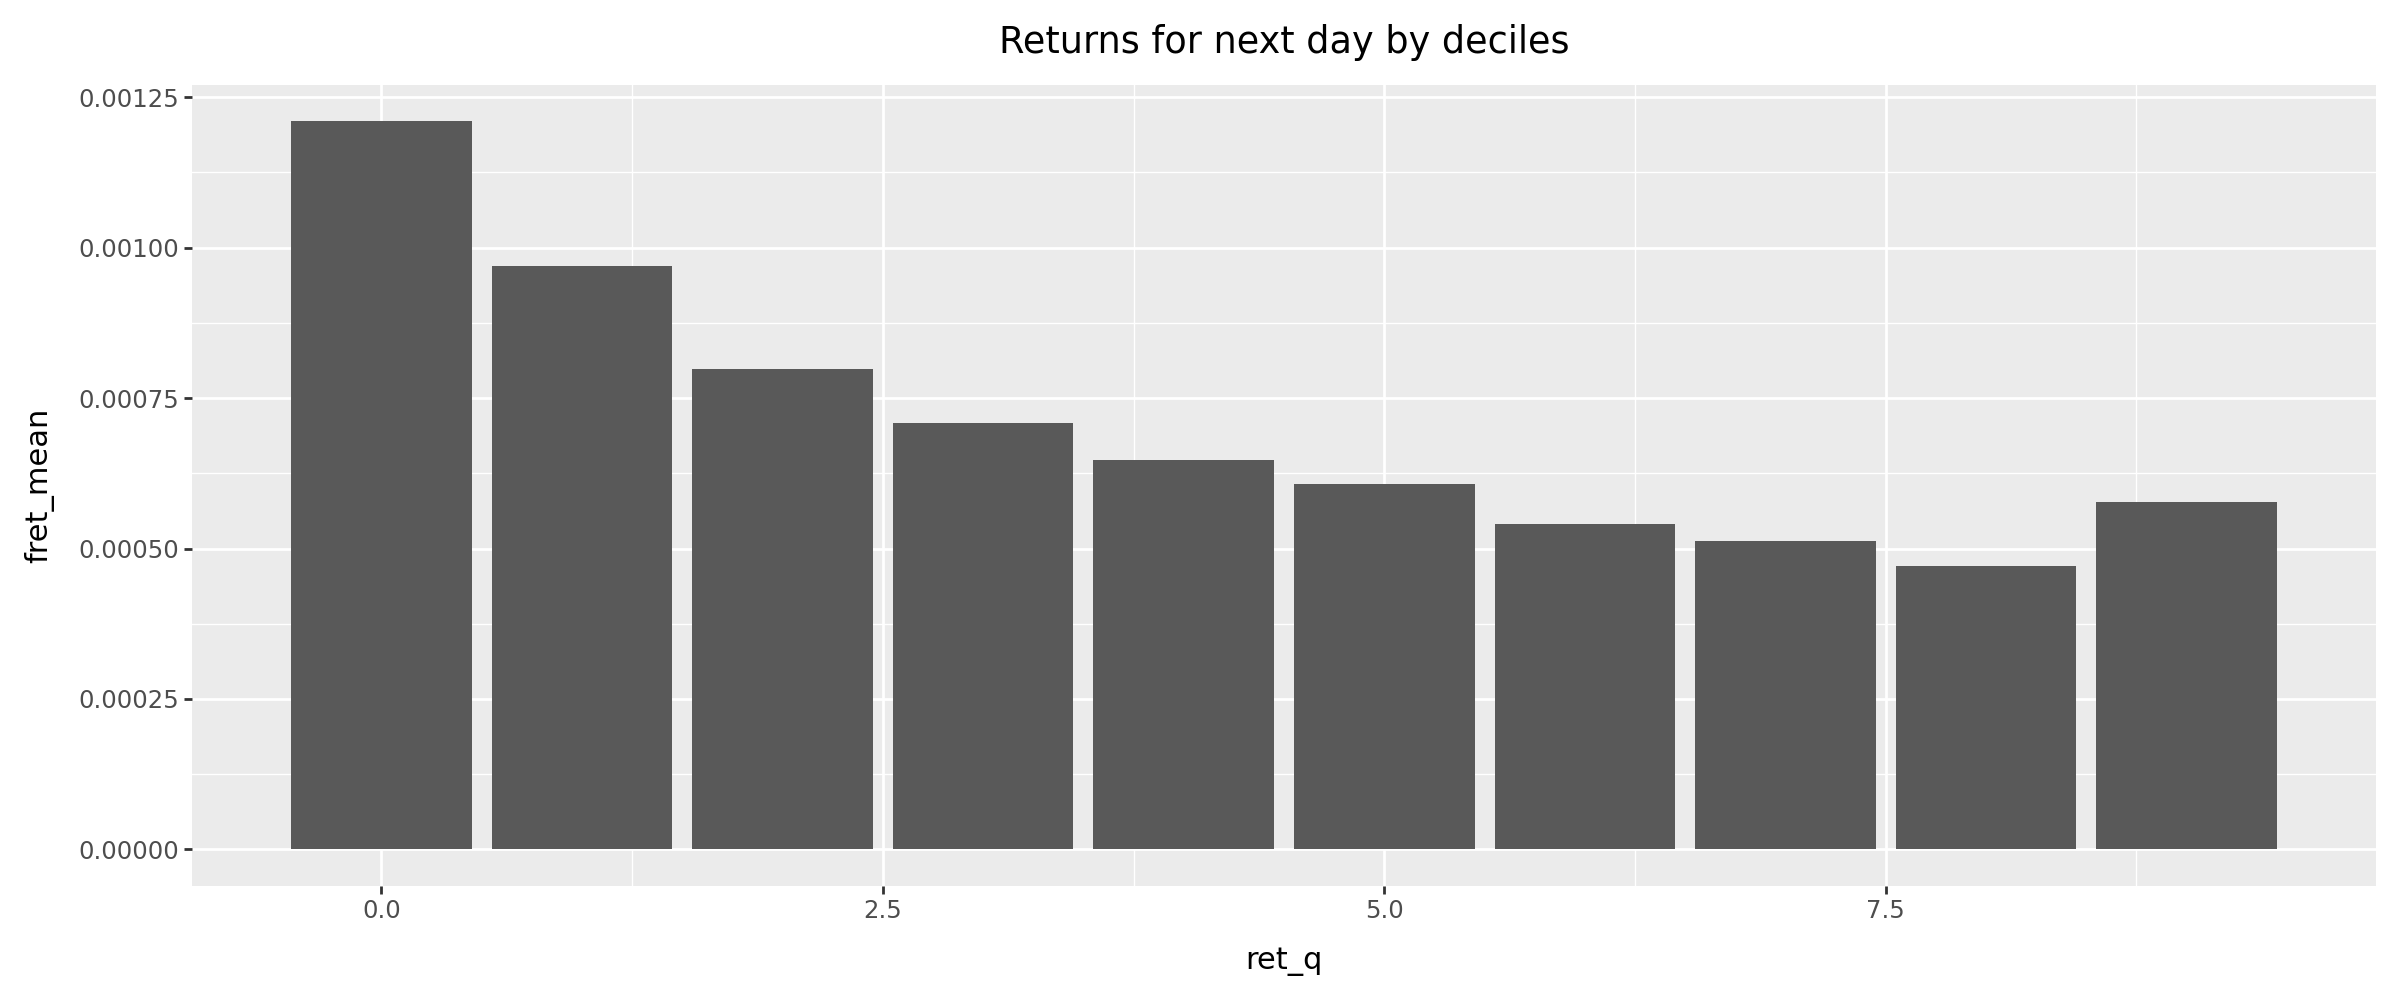

In [16]:
(
    ydq_1
    .group_by('ret_q')
    .agg(
        pl.col('fret').mean().alias('fret_mean')
    )
    .pipe(p9.ggplot)
    + p9.aes(x='ret_q', y='fret_mean')
    + p9.geom_bar(stat='identity')
    + p9.ggtitle("Returns for next day by deciles")
)

## What about relating last week's move to next week's move?

In [17]:
SHIFT = 5
NUM_QUANTILES = 10
LABELS = [str(x) for x in range(NUM_QUANTILES)]

ydq_1 = (
    yd1
    .group_by('Ticker', maintain_order=True)
    .agg(
        pl.all(), 
        pl.col('Close').pct_change(SHIFT).alias('ret'),
        pl.col('Close').pct_change(SHIFT).shift(-SHIFT).alias('fret')
    )
    .explode(pl.exclude('Ticker'))

    .drop_nulls()
    
    .with_columns(
        pl.col('ret')
        .qcut(quantiles=NUM_QUANTILES, labels=LABELS, allow_duplicates=True)
        .over("Date")
        .alias('ret_q').cast(pl.UInt32)
    )
)

if SHIFT > 1:
    date_selection = ydq_1.select('Date').unique().sort(by='Date').gather_every(SHIFT)
    ydq_1 = ydq_1.filter(pl.col('Date').is_in(date_selection))

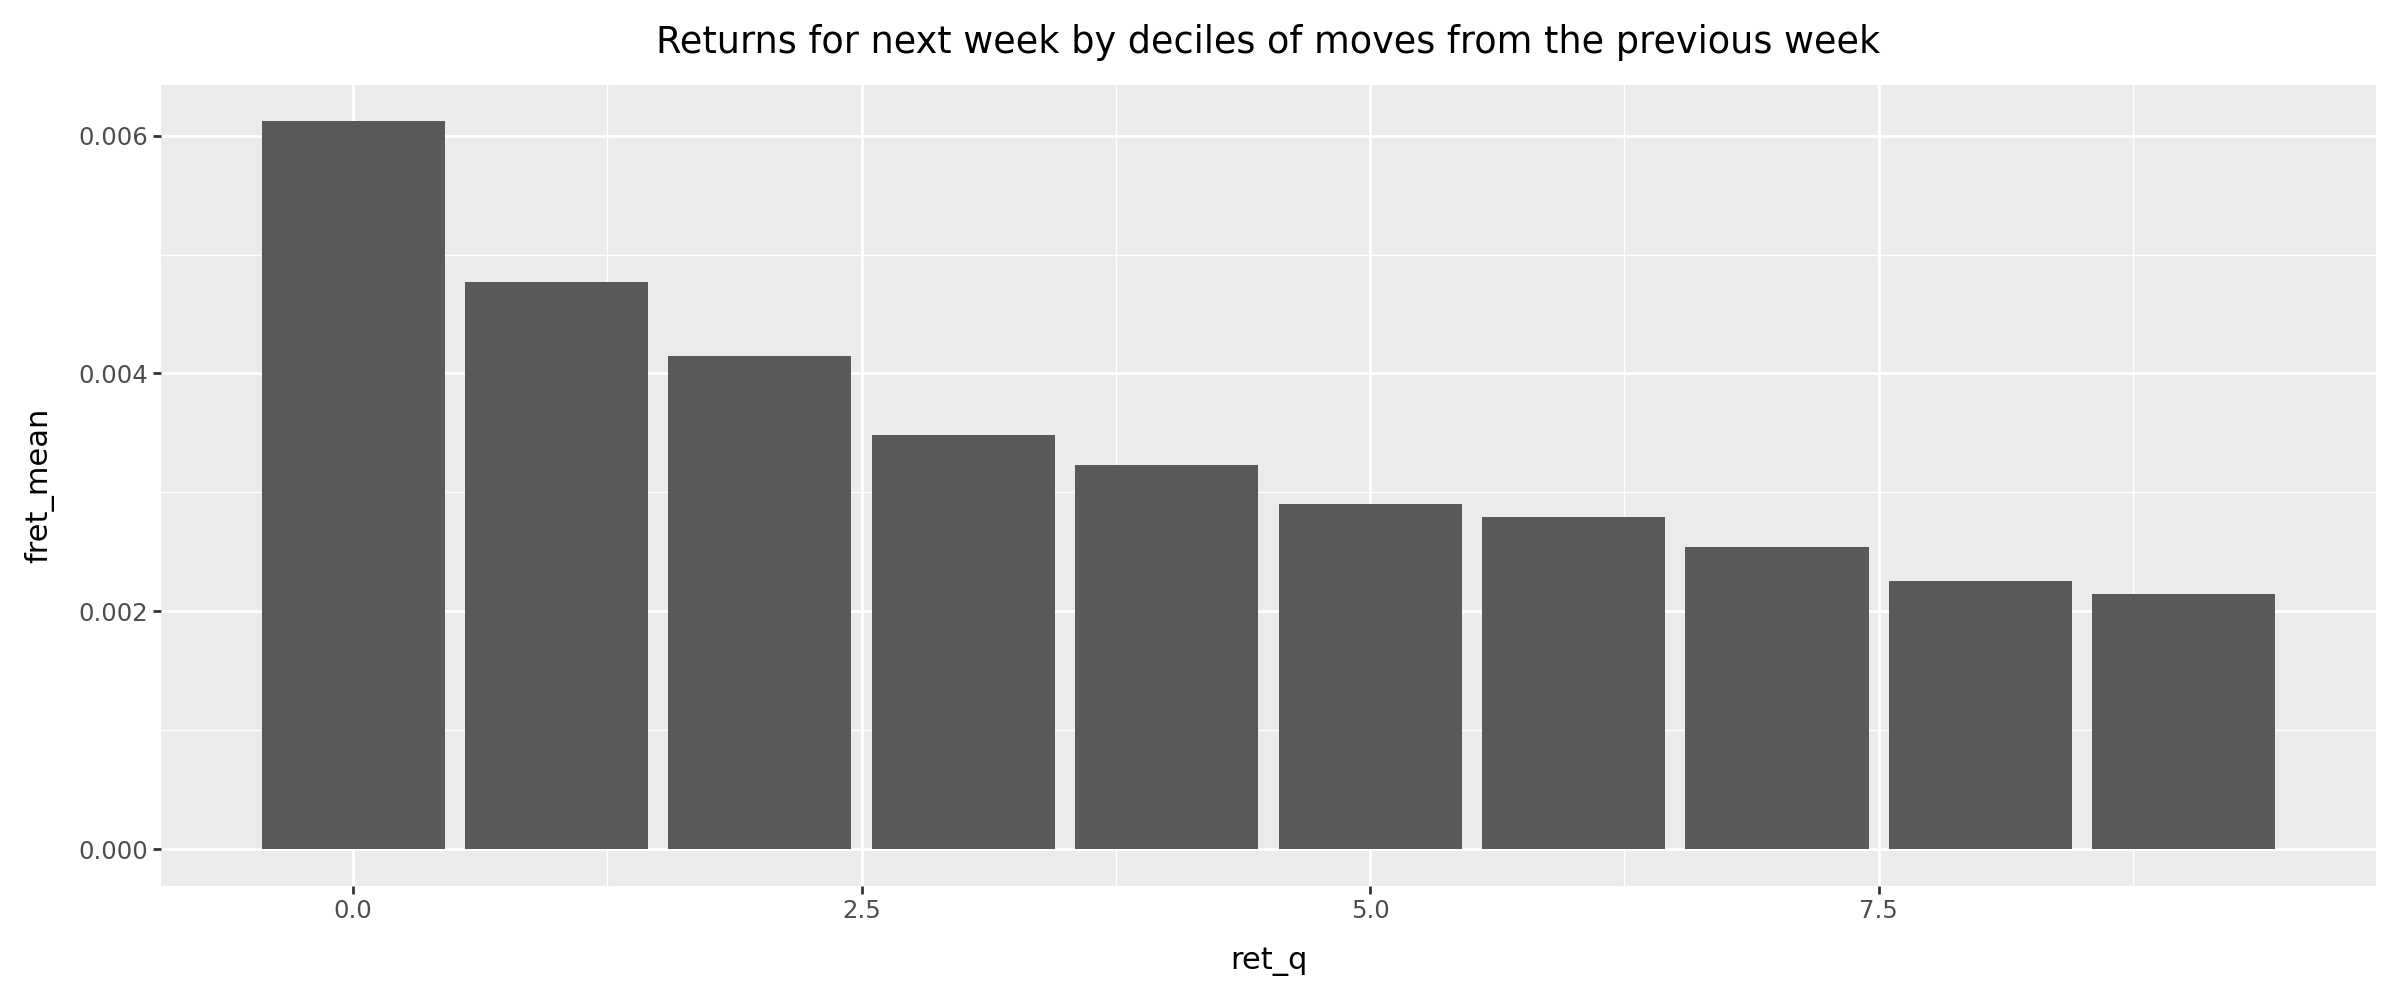

In [18]:
(
    ydq_1
    .group_by('ret_q')
    .agg(
        pl.col('fret').mean().alias('fret_mean')
    )
    .pipe(p9.ggplot)
    + p9.aes(x='ret_q', y='fret_mean')
    + p9.geom_bar(stat='identity')
    + p9.ggtitle("Returns for next week by deciles of moves from the previous week")
)

## A Naive strategy looking to buy the bottom decile

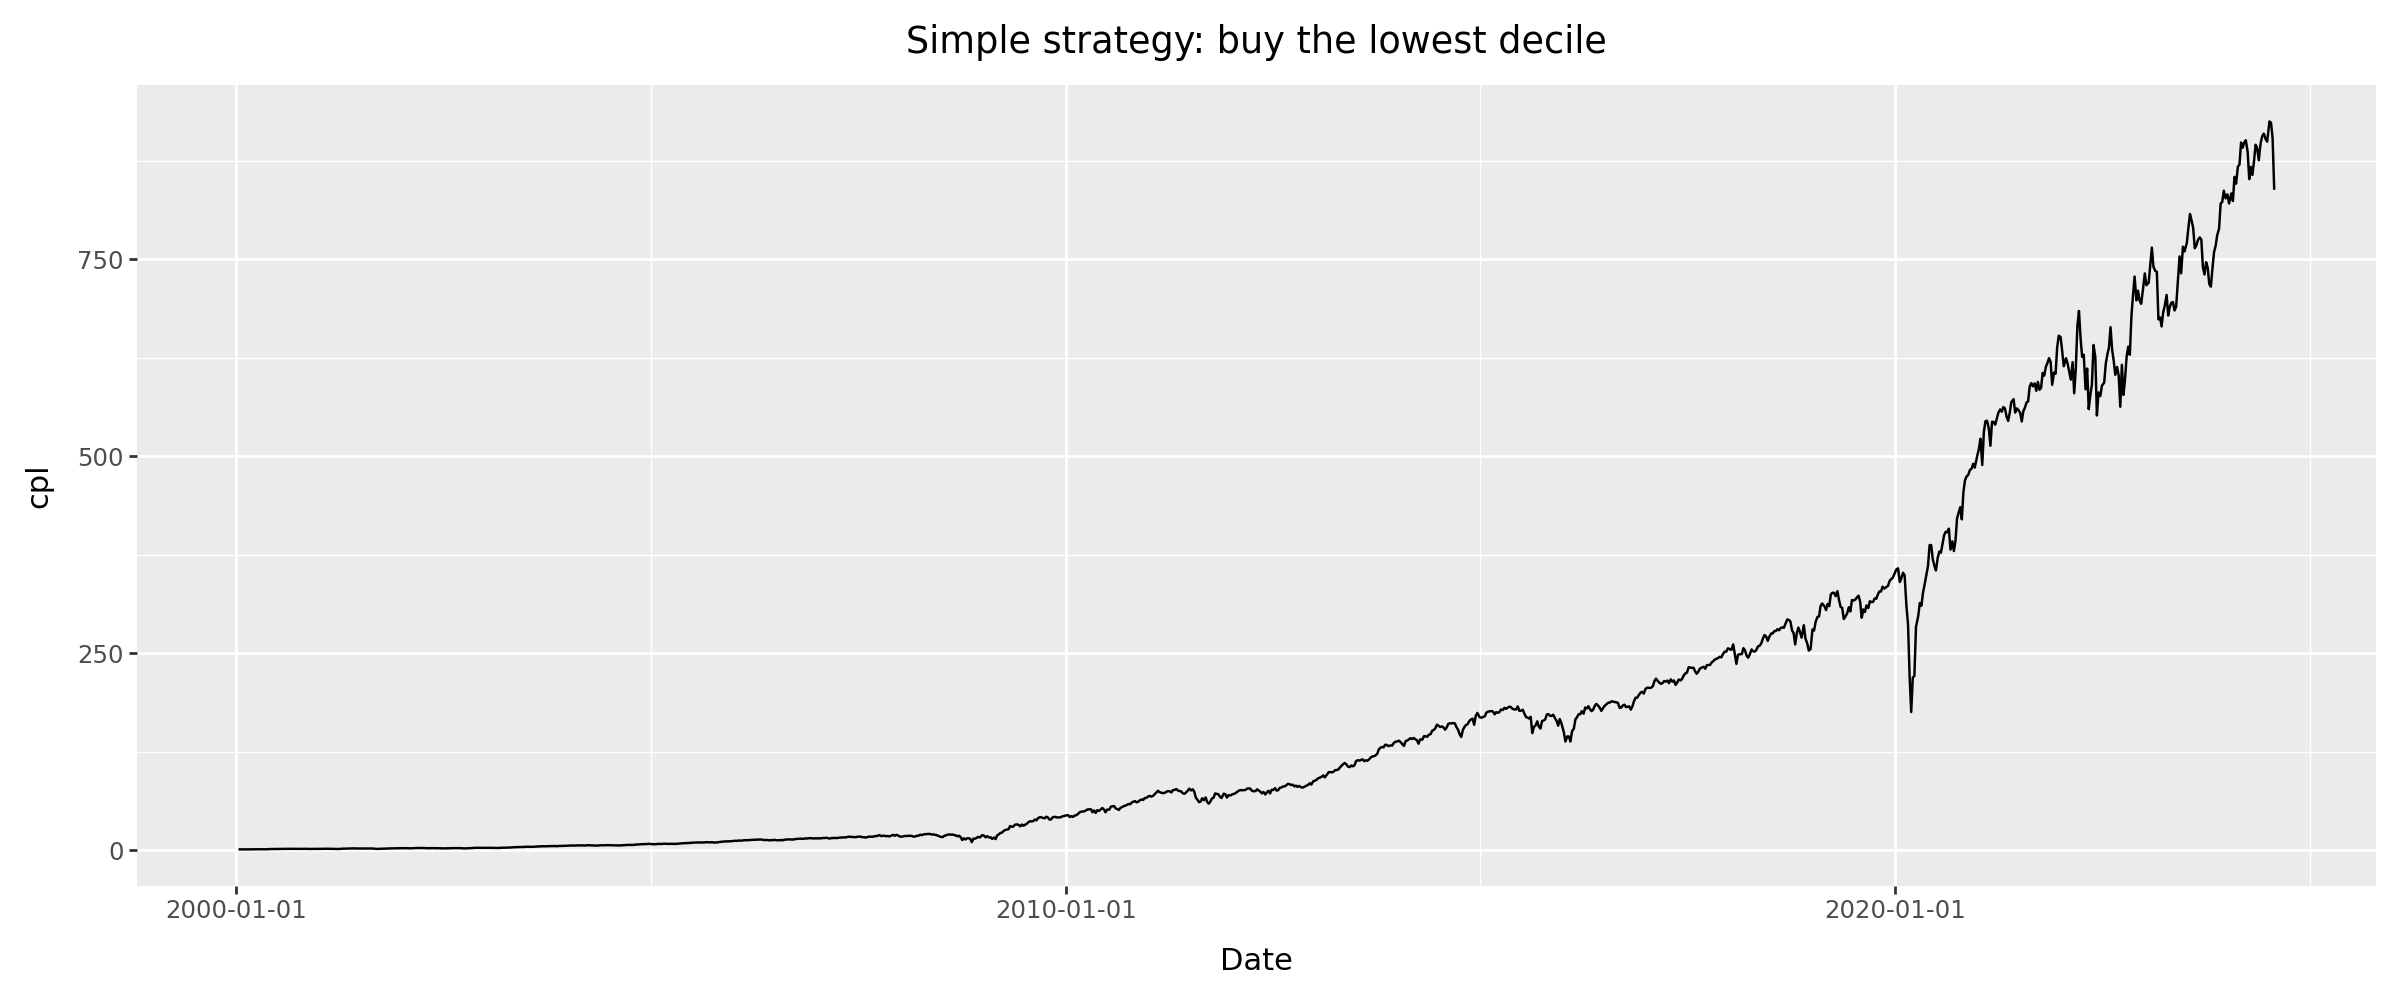

In [19]:
cpl = (
    ydq_1
    .sort(by=['Date','Ticker'])
    .with_columns(
        pl.when(pl.col('ret_q') == 0).then(1).otherwise(0).alias('flag'),
    )
    .with_columns(
        ( pl.col('flag') * pl.col('fret') ).alias('pl')
    )
    .filter( pl.col('flag') == 1)
    .group_by('Date')
    .agg(
        pl.col('pl').mean()
    )
    .with_columns(
        ( 1 + pl.col('pl') ).cum_prod().alias('cpl')
    )
    .select('Date', 'cpl')
)

(
    cpl
    .pipe(p9.ggplot)
    + p9.aes(x='Date', y='cpl')
    + p9.geom_line()
    + p9.ggtitle("Simple strategy: buy the lowest decile")
)


## Strategy Performance

In [20]:
tm = (cpl['Date'][-1] - cpl['Date'][0]).days / 365
cagr = (cpl['cpl'][-1]) ** (1/tm) - 1
vol = cpl['cpl'].pct_change().drop_nulls().std() * np.sqrt(252)

print(f"Cagr: {cagr*100:.2f}%, with vol: {vol*100:.2f}% giving a Sharpe Ratio of {cagr/vol:.2f}")

Cagr: 31.52%, with vol: 66.49% giving a Sharpe Ratio of 0.47


## Monthly Performance Table

In [21]:
MONTH_COLS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct' ,'Nov' , 'Dec']

(
    cpl
    .with_columns(
        pl.when( pl.col('Date').dt.month() != pl.col('Date').shift(-1).dt.month())
        .then(1).otherwise(0).alias('EOM')
    )
    .filter( pl.col('EOM') == 1)
    .with_columns(
        pl.col('cpl').pct_change().alias('ret')
    )
    .fill_null(0.0)
    .with_columns(
        pl.col('Date').dt.strftime('%b').alias('month'),
        pl.col('Date').dt.year().alias('year'),
    )
    .pivot(on='month', index='year', values='ret')
    .fill_null(0.0)
    .with_columns(
        pl.fold(acc=1, function=lambda x, y: x * y, exprs=(1 + pl.exclude('year'))).alias('Total')
    )
    .with_columns(
        pl.col('Total') - 1.0,
    )
    .to_pandas()
    .assign(year=lambda x: x.year.astype('int')).set_index('year')
    .style
    .format("{:.2%}")
    .background_gradient("Greens")

    # .style
    # .fmt_number(pl.exclude('year'), decimals=1)
    # .data_color(palette=['red','green'], na_color='grey')
)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
year,,,,,,,,,,,,,
2000,0.00%,8.37%,9.52%,2.70%,18.97%,7.95%,4.82%,9.03%,-8.18%,10.37%,-11.67%,5.57%,69.04%
2001,11.30%,-8.85%,-10.04%,34.63%,13.47%,-7.53%,7.77%,-15.39%,-1.82%,12.02%,7.94%,11.68%,55.86%
2002,-8.30%,11.04%,8.02%,-11.85%,2.66%,-9.05%,4.74%,5.88%,-8.98%,13.29%,13.38%,5.84%,24.22%
2003,-8.95%,-2.72%,11.19%,11.93%,13.89%,10.66%,-2.68%,13.43%,1.44%,7.38%,3.93%,4.24%,80.98%
2004,1.30%,6.85%,2.94%,-7.15%,6.49%,2.33%,-3.69%,1.73%,8.55%,4.41%,7.95%,1.50%,37.16%
2005,2.00%,2.07%,1.79%,0.18%,7.79%,7.25%,3.10%,0.86%,1.96%,4.50%,5.81%,4.38%,50.20%
2006,3.63%,4.23%,5.12%,1.04%,-4.20%,1.92%,-1.48%,5.33%,3.98%,2.34%,5.14%,-0.53%,29.36%
2007,2.76%,-6.00%,5.08%,4.37%,5.72%,0.06%,-1.84%,2.47%,10.13%,-2.28%,1.42%,0.80%,24.04%
2008,-3.96%,-3.79%,13.64%,4.12%,-1.96%,-12.89%,12.83%,-1.82%,-14.82%,-8.12%,-3.65%,30.87%,2.07%


## Does this relationship hold for Monthly Moves?

In [22]:
SHIFT = 20
NUM_QUANTILES = 10
LABELS = [str(x) for x in range(NUM_QUANTILES)]

ydq_1 = (
    yd1
    .group_by('Ticker', maintain_order=True)
    .agg(
        pl.all(), 
        pl.col('Close').pct_change(SHIFT).alias('ret'),
        pl.col('Close').pct_change(SHIFT).shift(-SHIFT).alias('fret')
    )
    .explode(pl.exclude('Ticker'))

    .drop_nulls()
    
    .with_columns(
        pl.col('ret')
        .qcut(quantiles=NUM_QUANTILES, labels=LABELS, allow_duplicates=True)
        .over("Date")
        .alias('ret_q').cast(pl.UInt32)
    )
)

if SHIFT > 1:
    date_selection = ydq_1.select('Date').unique().sort(by='Date').gather_every(SHIFT)
    ydq_1 = ydq_1.filter(pl.col('Date').is_in(date_selection))

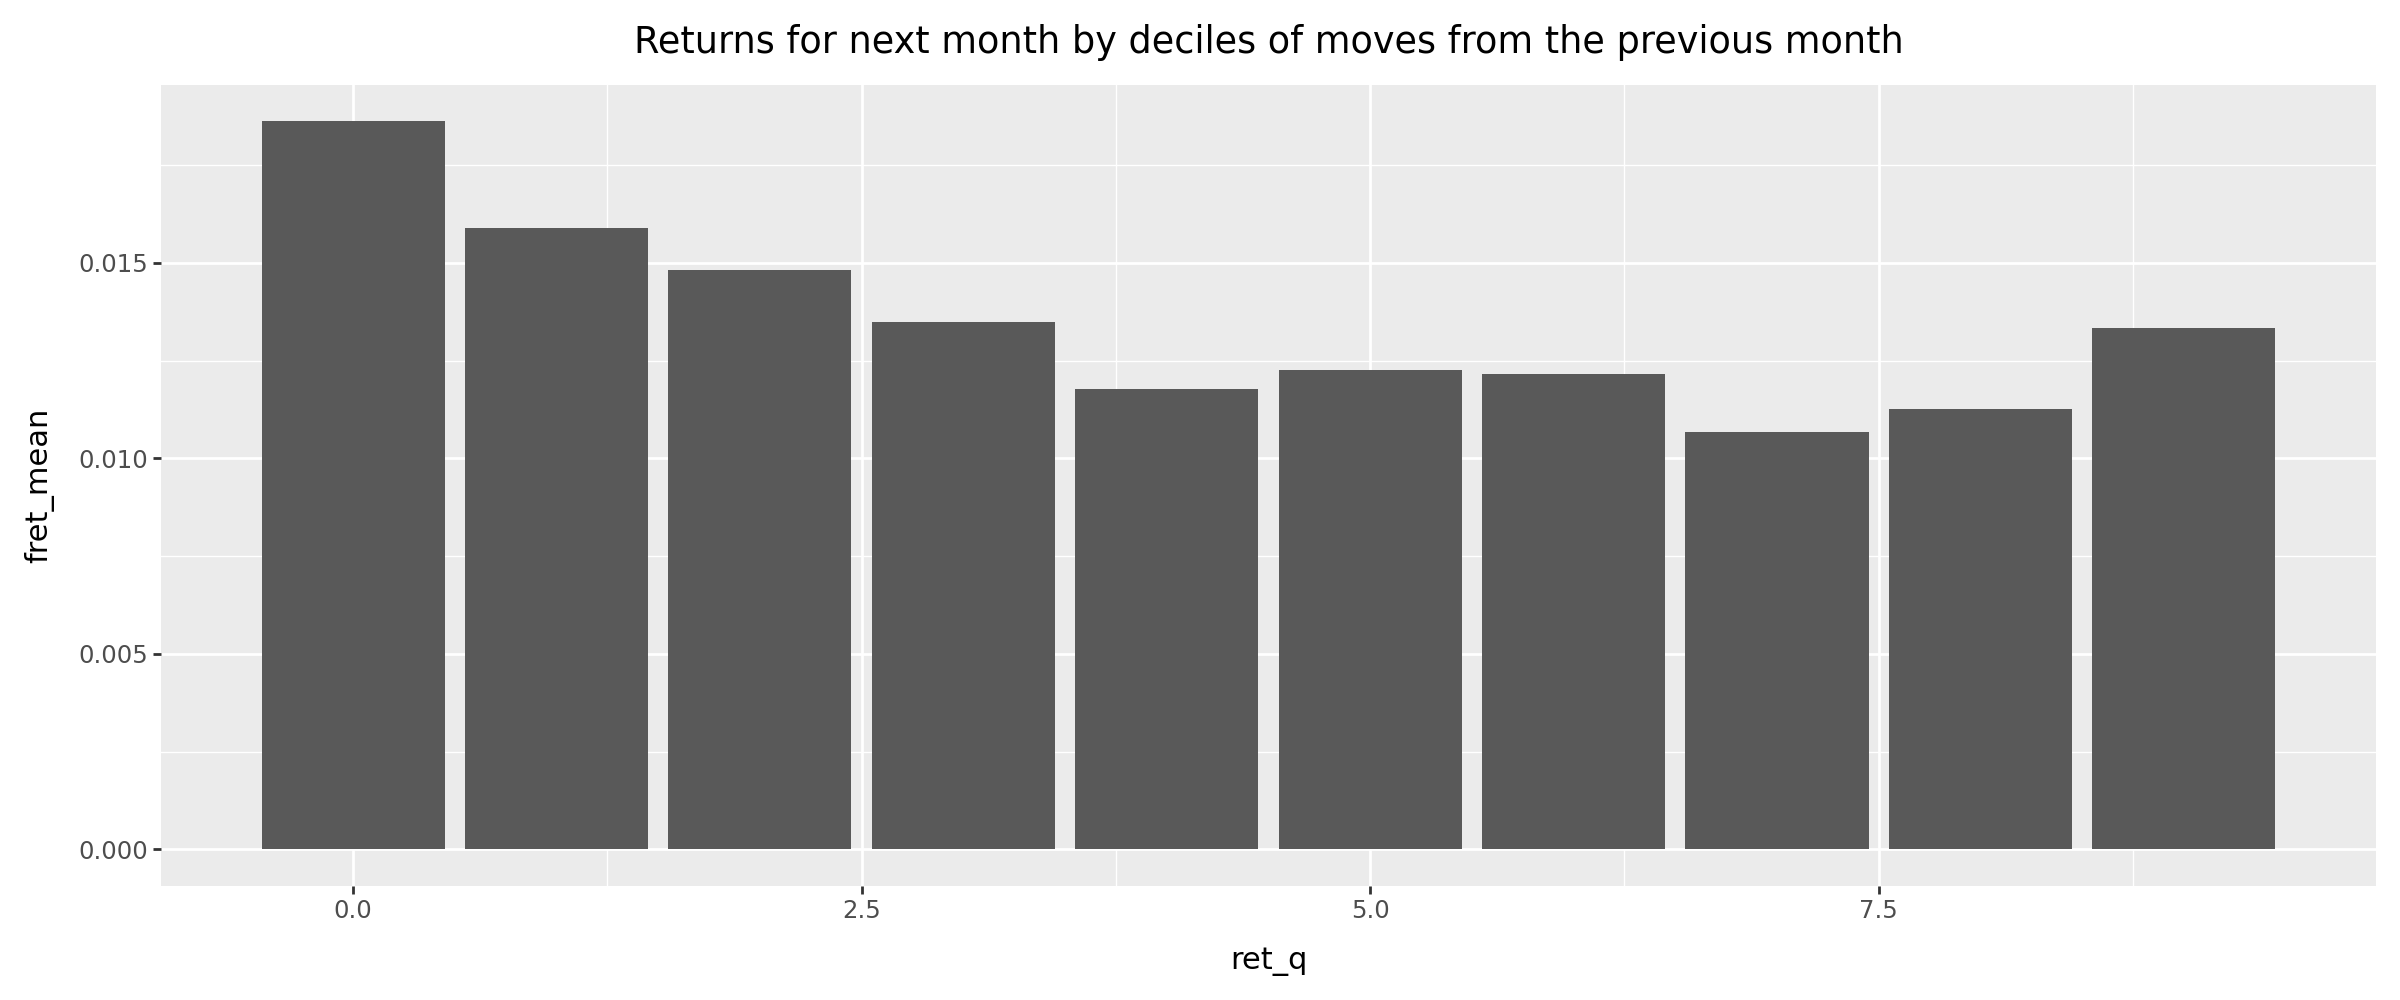

In [23]:
(
    ydq_1
    .group_by('ret_q')
    .agg(
        pl.col('fret').mean().alias('fret_mean')
    )
    .pipe(p9.ggplot)
    + p9.aes(x='ret_q', y='fret_mean')
    + p9.geom_bar(stat='identity')
    + p9.ggtitle("Returns for next month by deciles of moves from the previous month")
)